# Garbage Classification using Transfer Learning
> In this project, we aim to develop a sophisticated garbage classification system leveraging the EfficientNetV2B2 architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.

**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and transfer learning for automated waste sorting.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-06-29 11:07:17.993679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751195238.102050    1934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751195238.131102    1934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751195238.365076    1934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751195238.365148    1934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751195238.365150    1934 computation_placer.cc:177] computation placer alr

In [2]:
from tensorflow.keras.applications import ResNet50, EfficientNetV2B2, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
import kagglehub

path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")

os.replace(f"{path}/TrashType_Image_Dataset", "../dataset")

/home/shiva/Projects/scrapscope/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/home/shiva/.cache/kagglehub/datasets/farzadnekouei/trash-type-image-dataset/versions/1/TrashType_Image_Dataset' -> '../dataset'

## Data Preparation and Augmentation

We use ImageDataGenerator for data augmentation and to load images from the dataset directory.

In [5]:
dataset_path = "../dataset"
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)
class_names = list(train_generator.class_indices.keys())

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## Visualize Sample Images

Display a grid of sample images from the training set with their labels.

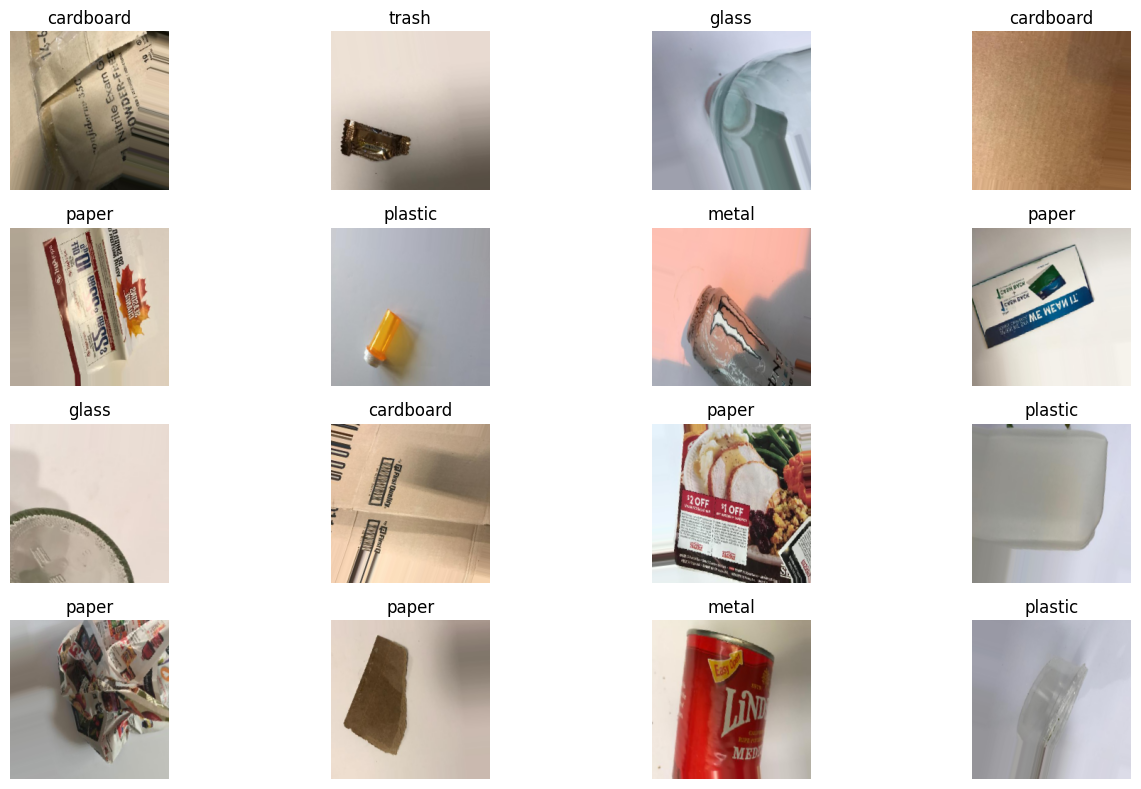

In [6]:
images, labels = next(train_generator)
plt.figure(figsize=(14, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Build the Model

We use MobileNetV2 as the base model for transfer learning, with custom dense layers on top.

In [7]:
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

I0000 00:00:1751195285.213911    1934 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
def create_model(base_model_name, input_shape, num_classes):
    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(
            weights="imagenet", include_top=False, input_shape=input_shape
        )
    elif base_model_name == "ResNet50":
        base_model = ResNet50(
            weights="imagenet", include_top=False, input_shape=input_shape
        )
    elif base_model_name == "EfficientNetV2B2":
        base_model = EfficientNetV2B2(
            weights="imagenet", include_top=False, input_shape=input_shape
        )
    elif base_model_name == "InceptionV3":
        base_model = InceptionV3(
            weights="imagenet", include_top=False, input_shape=input_shape
        )
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

In [9]:
def train_and_save_model(model_name, epochs=20, fine_tune_epochs=10):
    print(f"\n{'=' * 50}")
    print(f"Training {model_name}")
    print(f"{'=' * 50}")

    model, base_model = create_model(
        model_name, (img_size[0], img_size[1], 3), train_generator.num_classes
    )

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    print(f"Phase 1: Training with frozen {model_name} base...")
    history1 = model.fit(
        train_generator, epochs=epochs, validation_data=validation_generator, verbose=1
    )

    print(f"Phase 2: Fine-tuning {model_name}...")
    base_model.trainable = True

    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    history2 = model.fit(
        train_generator,
        epochs=fine_tune_epochs,
        validation_data=validation_generator,
        verbose=1,
    )

    model_filename = f"{model_name.lower()}.keras"
    model.save(model_filename)
    print(f"Model saved as {model_filename}")

    combined_history = {
        "accuracy": history1.history["accuracy"] + history2.history["accuracy"],
        "val_accuracy": history1.history["val_accuracy"]
        + history2.history["val_accuracy"],
        "loss": history1.history["loss"] + history2.history["loss"],
        "val_loss": history1.history["val_loss"] + history2.history["val_loss"],
    }

    return model, combined_history

## Train Multiple Models

Now we'll train different model architectures and save each one with its own filename.

In [10]:
model_architectures = ["MobileNetV2", "ResNet50", "EfficientNetV2B2", "InceptionV3"]

trained_models = {}
model_histories = {}

for model_name in model_architectures:
    try:
        model, history = train_and_save_model(
            model_name, epochs=15, fine_tune_epochs=10
        )
        trained_models[model_name] = model
        model_histories[model_name] = history
        print(f"✅ Successfully trained and saved {model_name}")
    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)}")
        continue

print(f"\n🎉 Training completed! Saved {len(trained_models)} models:")


Training MobileNetV2
Phase 1: Training with frozen MobileNetV2 base...
Phase 1: Training with frozen MobileNetV2 base...


/home/shiva/Projects/scrapscope/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1751195315.159210    3552 service.cc:152] XLA service 0x7f74f0010ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751195315.159268    3552 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-29 11:08:35.288454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751195316.086980    3552 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751195316.086980    3552 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-29 11:08:37.575581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 204 bytes spill stores, 204 bytes spill loads

2025-06-29 11:08:37.599785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.c

 2/64 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1250 - loss: 2.3968  

I0000 00:00:1751195327.420391    3552 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 3/64 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.1285 - loss: 2.3690

2025-06-29 11:08:49.640220: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694_0', 176 bytes spill stores, 524 bytes spill loads

2025-06-29 11:08:49.772966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:08:49.773111: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 112 bytes spill stores, 112 bytes spill loads

2025-06-29 11:08:49.901896: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 12 bytes spill stores, 12 bytes spill loads

2025-06-29 11:08:49.901896: I extern

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2666 - loss: 1.9276

2025-06-29 11:09:13.719701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 4 bytes spill stores, 4 bytes spill loads

2025-06-29 11:09:17.950738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 220 bytes spill stores, 220 bytes spill loads

2025-06-29 11:09:17.950738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 220 bytes spill stores, 220 bytes spill loads

2025-06-29 11:09:18.215891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 4 bytes spill stores, 4 bytes spill loads

2025-06-29 11:09:18.225159: I external/l

64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 597ms/step - accuracy: 0.2678 - loss: 1.9243 - val_accuracy: 0.5288 - val_loss: 1.2796
Epoch 2/15
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.5016 - loss: 1.3104 - val_accuracy: 0.6680 - val_loss: 1.0307
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.5016 - loss: 1.3104 - val_accuracy: 0.6680 - val_loss: 1.0307
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.5943 - loss: 1.0891 - val_accuracy: 0.6899 - val_loss: 0.9147
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.5943 - loss: 1.0891 - val_accuracy: 0.6899 - val_loss: 0.9147
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.5894 - loss: 1.0162 - val_accuracy: 0.7137 - val_loss: 0.8395
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.5894 - loss: 1.0162 - val_accuracy: 0.7137 - val_loss: 0.8395
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.6701 - loss: 0.9193 - val_accu

2025-06-29 11:16:23.111368: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 204 bytes spill stores, 204 bytes spill loads

2025-06-29 11:16:23.440557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004_0', 396 bytes spill stores, 2300 bytes spill loads

2025-06-29 11:16:23.440557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004_0', 396 bytes spill stores, 2300 bytes spill loads

2025-06-29 11:16:23.793066: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5599', 32 bytes spill stores, 32 bytes spill loads

2025-06-29 11:16:23.813907: 

 2/64 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.1641 - loss: 2.2010 

2025-06-29 11:16:32.040436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 12 bytes spill stores, 12 bytes spill loads

2025-06-29 11:16:32.352528: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:16:32.352528: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:16:32.678745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 112 bytes spill stores, 112 bytes spill loads

2025-06-29 11:16:32.678745: I external/loc

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.1841 - loss: 2.0755

2025-06-29 11:16:58.229187: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 4 bytes spill stores, 4 bytes spill loads

2025-06-29 11:16:58.713072: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 220 bytes spill stores, 220 bytes spill loads

2025-06-29 11:16:58.884315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:16:58.713072: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 220 bytes spill stores, 220 bytes spill loads

2025-06-29 11:16:58.884315: I external/l

64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 533ms/step - accuracy: 0.1845 - loss: 2.0738 - val_accuracy: 0.2346 - val_loss: 1.7099
Epoch 2/15
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.2345 - loss: 1.8118 - val_accuracy: 0.2266 - val_loss: 1.6983
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.2345 - loss: 1.8118 - val_accuracy: 0.2266 - val_loss: 1.6983
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.2404 - loss: 1.7549 - val_accuracy: 0.2644 - val_loss: 1.6889
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.2404 - loss: 1.7549 - val_accuracy: 0.2644 - val_loss: 1.6889
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.2711 - loss: 1.6933 - val_accuracy: 0.2306 - val_loss: 1.6872
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.2711 - loss: 1.6933 - val_accuracy: 0.2306 - val_loss: 1.6872
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.2494 - loss: 1.7211 - val_accu

2025-06-29 11:24:37.778884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640_0', 32 bytes spill stores, 32 bytes spill loads

2025-06-29 11:24:37.994498: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 504 bytes spill stores, 504 bytes spill loads

2025-06-29 11:24:38.035364: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 40 bytes spill stores, 40 bytes spill loads

2025-06-29 11:24:38.072492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16018', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:24:37.994498: I exte

41/64 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1978 - loss: 1.7842

2025-06-29 11:25:08.924049: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 11:25:09.274259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 12 bytes spill stores, 12 bytes spill loads

2025-06-29 11:25:09.274259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 12 bytes spill stores, 12 bytes spill loads

2025-06-29 11:25:09.564919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15640', 264 bytes spill stores, 264 bytes spill loads

2025-06-29 11:25:09.589913: I extern

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.2018 - loss: 1.7749

2025-06-29 11:25:38.038693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2947_0', 20 bytes spill stores, 20 bytes spill loads

2025-06-29 11:25:38.155657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2947', 44 bytes spill stores, 44 bytes spill loads

2025-06-29 11:25:38.238608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2947', 500 bytes spill stores, 500 bytes spill loads

2025-06-29 11:25:38.349041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2947', 44 bytes spill stores, 44 bytes spill loads

2025-06-29 11:25:38.349041: I extern

64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 821ms/step - accuracy: 0.2020 - loss: 1.7746 - val_accuracy: 0.2346 - val_loss: 1.7182
Epoch 2/15
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.2195 - loss: 1.7426 - val_accuracy: 0.2485 - val_loss: 1.7182
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.2195 - loss: 1.7426 - val_accuracy: 0.2485 - val_loss: 1.7182
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.2329 - loss: 1.7331 - val_accuracy: 0.2346 - val_loss: 1.7154
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.2329 - loss: 1.7331 - val_accuracy: 0.2346 - val_loss: 1.7154
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.2125 - loss: 1.7422 - val_accuracy: 0.2346 - val_loss: 1.7191
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.2125 - loss: 1.7422 - val_accuracy: 0.2346 - val_loss: 1.7191
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.2453 - loss: 1.7214 - val_accu

2025-06-29 11:30:05.510451: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-29 11:30:05.702836: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-29 11:30:06.613237: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-29 11:30:06.613237: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-29 11:30:06.864416: E external/local_xla/xla/stream_

64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 970ms/step - accuracy: 0.1751 - loss: 1.8358 - val_accuracy: 0.1849 - val_loss: 1.7553
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 970ms/step - accuracy: 0.1751 - loss: 1.8358 - val_accuracy: 0.1849 - val_loss: 1.7553
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.2007 - loss: 1.7912 - val_accuracy: 0.2306 - val_loss: 1.7274
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.2007 - loss: 1.7912 - val_accuracy: 0.2306 - val_loss: 1.7274
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.2397 - loss: 1.7651 - val_accuracy: 0.2744 - val_loss: 1.6950
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.2397 - loss: 1.7651 - val_accuracy: 0.2744 - val_loss: 1.6950
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.2532 - loss: 1.7491 - val_accuracy: 0.3121 - val_loss: 1.6795
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.2532 - loss: 1.7491 - val_accuracy: 0.3

## Compare Model Performance

Let's compare the performance of all trained models.

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
for model_name, history in model_histories.items():
    plt.plot(history["accuracy"], label=f"{model_name} Train")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
for model_name, history in model_histories.items():
    plt.plot(history["val_accuracy"], label=f"{model_name} Val")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
for model_name, history in model_histories.items():
    plt.plot(history["loss"], label=f"{model_name} Train")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 4)
for model_name, history in model_histories.items():
    plt.plot(history["val_loss"], label=f"{model_name} Val")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

print("\n📊 Final Performance Summary:")
print("=" * 60)
for model_name, history in model_histories.items():
    final_train_acc = history["accuracy"][-1]
    final_val_acc = history["val_accuracy"][-1]
    final_train_loss = history["loss"][-1]
    final_val_loss = history["val_loss"][-1]

    print(f"{model_name}:")
    print(f"  Train Accuracy: {final_train_acc:.4f}")
    print(f"  Val Accuracy:   {final_val_acc:.4f}")
    print(f"  Train Loss:     {final_train_loss:.4f}")
    print(f"  Val Loss:       {final_val_loss:.4f}")
    print(f"  Saved as:       {model_name.lower()}.keras")
    print("-" * 40)

## Model Testing and Evaluation

Load the best performing model and evaluate it on test data with detailed metrics.

In [ ]:
best_model_name = max(
    model_histories.keys(), key=lambda x: model_histories[x]["val_accuracy"][-1]
)
best_model = trained_models[best_model_name]
best_val_acc = model_histories[best_model_name]["val_accuracy"][-1]

print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Best Validation Accuracy: {best_val_acc:.4f}")
print(f"💾 Model file: {best_model_name.lower()}.keras")

In [ ]:
validation_generator.reset()
val_steps = validation_generator.samples // batch_size + 1
Y_pred = best_model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes[: len(y_pred)]

print(f"\n📈 Detailed Classification Report for {best_model_name}:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [ ]:
validation_generator.reset()
val_images, val_labels = next(validation_generator)
predictions = best_model.predict(val_images)
predicted_probs = np.max(predictions, axis=1)

plt.figure(figsize=(16, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(val_images[i])
    true_label = class_names[np.argmax(val_labels[i])]
    pred_label = class_names[np.argmax(predictions[i])]
    confidence = predicted_probs[i]

    if true_label == pred_label:
        color = "green"
        status = "✓"
    else:
        color = "red"
        status = "✗"

    plt.title(
        f"{status} True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
        color=color,
        fontsize=9,
    )
    plt.axis("off")
plt.suptitle(f"Predictions with {best_model_name}", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

validation_generator.reset()
val_steps = validation_generator.samples // batch_size + 1
Y_pred = best_model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes[: len(y_pred)]

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

performance_df = {
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support,
}

print(f"\n📊 Per-Class Performance Analysis - {best_model_name}")
print("=" * 80)
for i, class_name in enumerate(class_names):
    print(
        f"{class_name:12} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}"
    )

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(class_names))
width = 0.25

plt.bar(x_pos - width, precision, width, label="Precision", alpha=0.8)
plt.bar(x_pos, recall, width, label="Recall", alpha=0.8)
plt.bar(x_pos + width, f1, width, label="F1-Score", alpha=0.8)

plt.xlabel("Classes")
plt.ylabel("Score")
plt.title(f"Per-Class Performance Metrics - {best_model_name}")
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def predict_single_image(model, image_path, class_names, img_size=(224, 224)):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]

    all_predictions = {
        class_names[i]: prediction[0][i] for i in range(len(class_names))
    }

    return {
        "predicted_class": predicted_class,
        "confidence": confidence,
        "all_predictions": all_predictions,
    }


print("✅ Prediction function ready!")
print("Usage: predict_single_image(best_model, 'path/to/image.jpg', class_names)")
print(
    "Returns: {'predicted_class': 'class_name', 'confidence': 0.95, 'all_predictions': {...}}"
)